### 加载主要库

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels
import os
import geopandas as gpd
import matplotlib.cm as cm
from requests import get
from urllib.parse import urlparse

### 定义下载函数

In [64]:
def cache_data(src:str, dest:str) -> str:

    url = urlparse(src)
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename

    if not os.path.isfile(dfn):       
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)     
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)         
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)         
        print('Done downloading...')
    else:
        print(f"Found {dfn} locally!")
    return dfn

### 下载伦敦边界等矢量

In [65]:
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/Boroughs.gpkg locally!
Found data/Water.gpkg locally!
Found data/Greenspace.gpkg locally!
Done.


In [66]:
#检查边界投影
for g in [boros,water,green]:
    print(g.crs)

epsg:27700
epsg:27700
epsg:27700


### 下载初步清理后的inside airbnb数据集

In [67]:
#下载数据集，删除无用属性列后13MB，数据放在我的github上下载至本地
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/TiannanGe/CASA/blob/main/CASA13Foundation/' # source path
fn = 'listings.csv'
df = gpd.read_file( cache_data(spath + fn + '?raw=true', ddir) )
print('Done.')

Found data/listings.csv locally!
Done.


In [68]:
#加载数据，共69351行
df = pd.read_csv('data/listings.csv',encoding='latin-1')
df

/tmp/ipykernel_29024/2681182057.py:2: DtypeWarning: Columns (24,25,28,29,31,32,33,34,35,36,37,38,39,40,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/listings.csv',encoding='latin-1')


,id,host_location,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53
0,1.391300e+04,"London, United Kingdom",80%,70%,f,LB of Islington,3,4,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.540000e+04,"Kensington, United Kingdom",67%,29%,f,Chelsea,1,12,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.845320e+05,"London, United Kingdom",90%,67%,f,Shoreditch,1,3,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.063320e+05,"London, United Kingdom",100%,73%,t,Bethnal Green,2,5,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.740200e+04,"London, United Kingdom",90%,87%,f,Fitzrovia,6,32,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69346,9.671724e+06,"England, United Kingdom",100%,0%,f,Greenwich,15,15,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69347,2.027796e+07,"London, United Kingdom",100%,86%,t,NaN,1,1,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69348,2.051270e+07,"London, United Kingdom",83%,70%,f,NaN,1,1,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69349,4.969855e+07,"London, United Kingdom",NaN,80%,f,NaN,1,1,t,t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 爱彼迎数据清理

In [69]:
#转换为浮点型，按需转换
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["review_scores_communication"] = pd.to_numeric(df["review_scores_communication"], errors="coerce")
df["review_scores_location"] = pd.to_numeric(df["review_scores_location"], errors="coerce")
df["review_scores_value"] = pd.to_numeric(df["review_scores_value"], errors="coerce")
df["calculated_host_listings_count"] = pd.to_numeric(df["calculated_host_listings_count"], errors="coerce")
df["availability_365"] = pd.to_numeric(df["availability_365"], errors="coerce")
df["number_of_reviews"] = pd.to_numeric(df["number_of_reviews"], errors="coerce")
df["number_of_reviews_ltm"] = pd.to_numeric(df["number_of_reviews_ltm"], errors="coerce")
df["review_scores_rating"] = pd.to_numeric(df["review_scores_rating"], errors="coerce")
df["review_scores_cleanliness"] = pd.to_numeric(df["review_scores_cleanliness"], errors="coerce")
df["beds"] = pd.to_numeric(df["beds"], errors="coerce")
df["bedrooms"] = pd.to_numeric(df["bedrooms"], errors="coerce")
df["accommodates"] = pd.to_numeric(df["accommodates"], errors="coerce")

#删除空列
df.drop(df.columns[df.columns.get_loc('calculated_host_listings_count'):], axis=1, inplace=True)

#删除经纬度的空值
df.drop(df[df.latitude.isna()].index.array, axis=0, inplace=True)
df.drop(df[df.longitude.isna()].index.array, axis=0, inplace=True)
#删除经纬度的字符型数据，保留数值型
df = df[df["latitude"].apply(lambda x: isinstance(x, (int, float)))]
df = df[df["longitude"].apply(lambda x: isinstance(x, (int, float)))]
#清理后剩余68541行
print(f"After delete Data frame is {df.shape[0]:,} x {df.shape[1]}")

After delete Data frame is 68,541 x 27


In [70]:
#对价格做清理
df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')
df["price"] = pd.to_numeric(df["price"], errors="coerce")

/tmp/ipykernel_29024/2534484441.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].astype(str).str.replace(',', '').str.replace('$', '')


In [71]:
df

,id,host_location,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,beds,price,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value
0,1.391300e+04,"London, United Kingdom",80%,70%,f,LB of Islington,3,4,t,t,...,1.0,50.0,343.0,30.0,9.0,4.90,4.89,4.93,4.75,4.82
1,1.540000e+04,"Kensington, United Kingdom",67%,29%,f,Chelsea,1,12,t,t,...,1.0,75.0,70.0,89.0,0.0,4.79,4.88,4.82,4.93,4.73
2,2.845320e+05,"London, United Kingdom",90%,67%,f,Shoreditch,1,3,t,t,...,2.0,90.0,222.0,42.0,1.0,4.32,4.03,4.86,4.72,4.31
3,1.063320e+05,"London, United Kingdom",100%,73%,t,Bethnal Green,2,5,t,t,...,1.0,55.0,74.0,65.0,0.0,4.84,4.71,4.93,4.92,4.83
4,1.740200e+04,"London, United Kingdom",90%,87%,f,Fitzrovia,6,32,t,t,...,3.0,379.0,249.0,51.0,8.0,4.74,4.69,4.69,4.88,4.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69346,9.671724e+06,"England, United Kingdom",100%,0%,f,Greenwich,15,15,t,t,...,1.0,55.0,0.0,67.0,1.0,4.90,4.94,4.97,4.86,4.93
69347,2.027796e+07,"London, United Kingdom",100%,86%,t,NaN,1,1,t,t,...,3.0,201.0,0.0,61.0,12.0,4.90,4.84,4.93,5.00,4.80
69348,2.051270e+07,"London, United Kingdom",83%,70%,f,NaN,1,1,t,t,...,5.0,246.0,4.0,6.0,6.0,5.00,4.67,5.00,5.00,5.00
69349,4.969855e+07,"London, United Kingdom",NaN,80%,f,NaN,1,1,t,t,...,1.0,250.0,2.0,9.0,4.0,5.00,5.00,5.00,5.00,4.78


In [72]:
#检查数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68541 entries, 0 to 69350
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           68541 non-null  float64
 1   host_location                56263 non-null  object 
 2   host_response_rate           42131 non-null  object 
 3   host_acceptance_rate         44400 non-null  object 
 4   host_is_superhost            68515 non-null  object 
 5   host_neighbourhood           42964 non-null  object 
 6   host_listings_count          68510 non-null  object 
 7   host_total_listings_count    68533 non-null  object 
 8   host_has_profile_pic         68535 non-null  object 
 9   host_identity_verified       68536 non-null  object 
 10  neighbourhood_cleansed       68540 non-null  object 
 11  latitude                     68541 non-null  float64
 12  longitude                    68541 non-null  float64
 13  property_type   

### 清理伦敦范围外的坐标值

In [73]:
#取伦敦范围内的坐标值
df = df[(df["longitude"] >= -0.5236) & (df["longitude"] <= 0.30515)]
df = df[(df["latitude"] >= 51.27248) & (df["latitude"] <= 51.70893)]

In [74]:
#检查airbnb边界范围
print(f"The bottom-left corner is {df.longitude.min()}, {df.latitude.min()}")
print(f"The top-right corner is {df.longitude.max()}, {df.latitude.max()}")

The bottom-left corner is -0.5236, 51.27248
The top-right corner is 0.30515, 51.70893


### 定义Airbnb投影

In [75]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

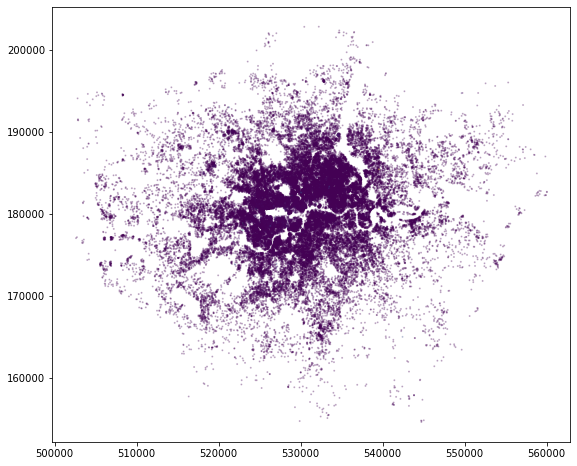

In [76]:
#投影为英国坐标并绘图，绘图耗时5秒
gdf.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

In [77]:
#定义为英国本土坐标
gdf = gdf.to_crs('epsg:27700')
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:27700
[502615.87511762 154633.50599878 560027.49389306 202832.88761803]


### 将清理过的csv文件保存为feather格式文件至本地

In [78]:
print(f"Using 'listings.feather' as basis for saving data...")
gdf.to_feather(os.path.join('data',fn.replace('.csv','.feather')))

Using 'listings.feather' as basis for saving data...


### 初步分析、直方图、箱型图

In [79]:
#价格区间，平均数，中位数
print(f"The range of price is ${gdf.price.min():,.2f} to ${gdf.price.max():,.2f}")
print(f"The mean and median of the price are ${gdf.price.mean():,.2f} and ${gdf.price.median():,.2f}")

The range of price is $0.00 to $25,000.00
The mean and median of the price are $170.39 and $99.00


(0.0, 2500.0)

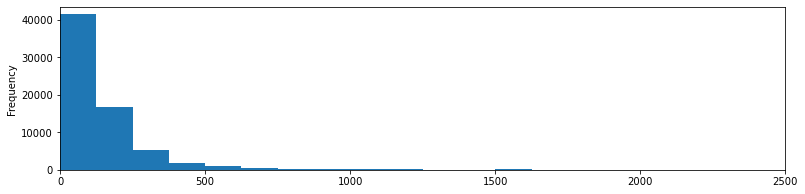

In [80]:
#价格直方图
ax = gdf.price.plot.hist(bins=200, figsize=(13,3)); # Oooooh, let's use a *pandas* method here
ax.set_xlim(0,2500)

(0.0, 2500.0)

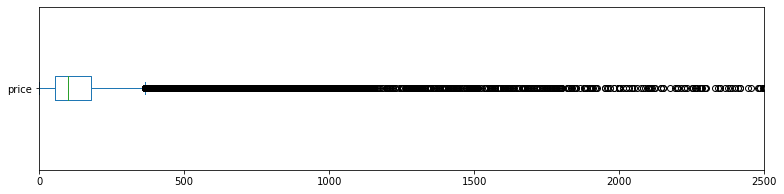

In [81]:
#价格箱型图
ax = gdf.price.plot.box(vert=False, figsize=(13,3))
ax.set_xlim(0,2500)

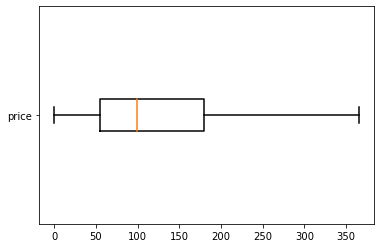

In [82]:
#价格箱型图1
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);

gdf has 68,492 rows.
gdf now has 67,478 rows.
The range of price is 7.00 to 1,000.00
The range of ln(price) is 1.9459 to 6.9078


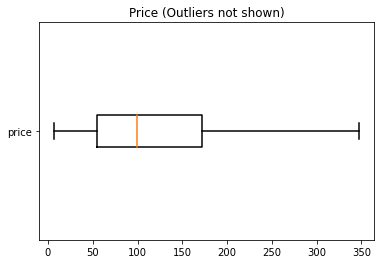

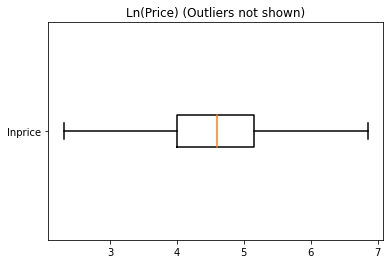

In [83]:
#价格箱型图2
print(f"gdf has {gdf.shape[0]:,.0f} rows.")
gdf.drop(gdf[gdf.price==0].index, axis=0, inplace=True)
gdf.drop(gdf[gdf.price < 5].index, axis=0, inplace=True)
gdf.drop(gdf[gdf.price > 1000].index, axis=0, inplace=True)
gdf['lnprice'] = np.log(gdf.price)#价格对数
print(f"gdf now has {gdf.shape[0]:,.0f} rows.")
print(f"The range of price is {gdf.price.min():,.2f} to {gdf.price.max():,.2f}")
print(f"The range of ln(price) is {gdf.lnprice.min():,.4f} to {gdf.lnprice.max():,.4f}")
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Price (Outliers not shown)")
plt.show()
gdf.lnprice.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Ln(Price) (Outliers not shown)")
plt.show()

### Airbnb房源每晚价格的自然对数图

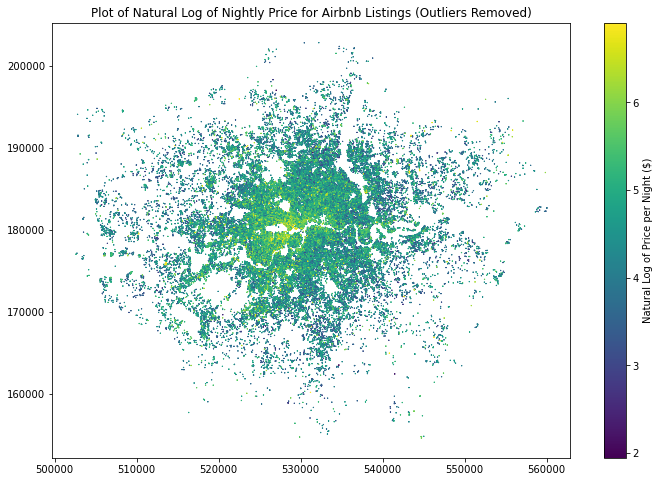

In [84]:
#Airbnb房源每晚价格的自然对数图，出图等待五秒
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)");

### Airbnb房源每晚价格的自然对数图（伦敦中心）

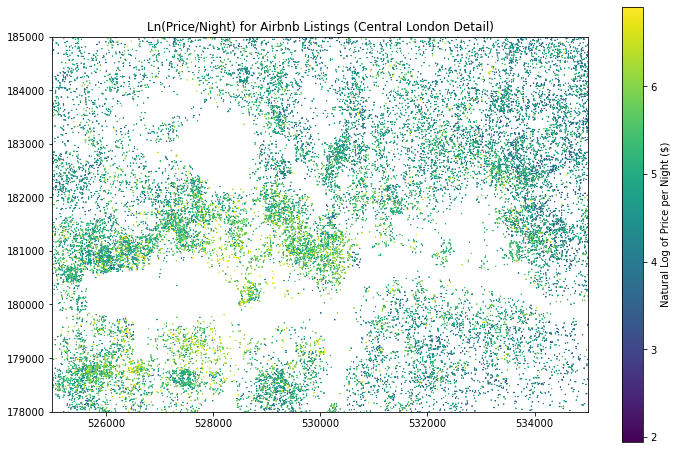

In [85]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Ln(Price/Night) for Airbnb Listings (Central London Detail)")
ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000]);

(178000.0, 185000.0)

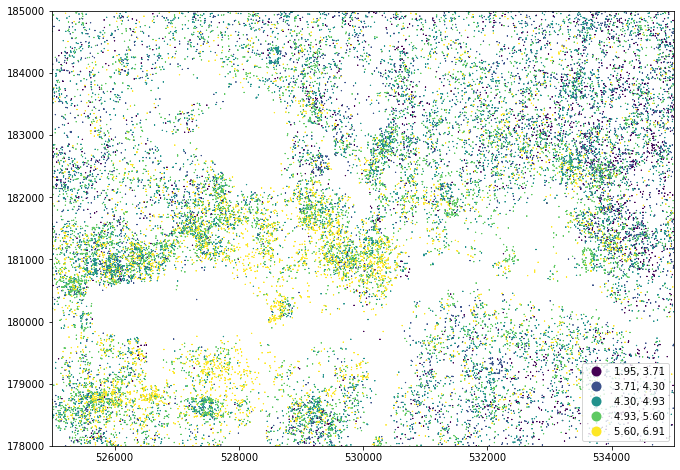

In [86]:
#出图等待
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True); # Note that the legend *label* had to go -- there are other ways to add it

ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])

### 叠加出图（局部）

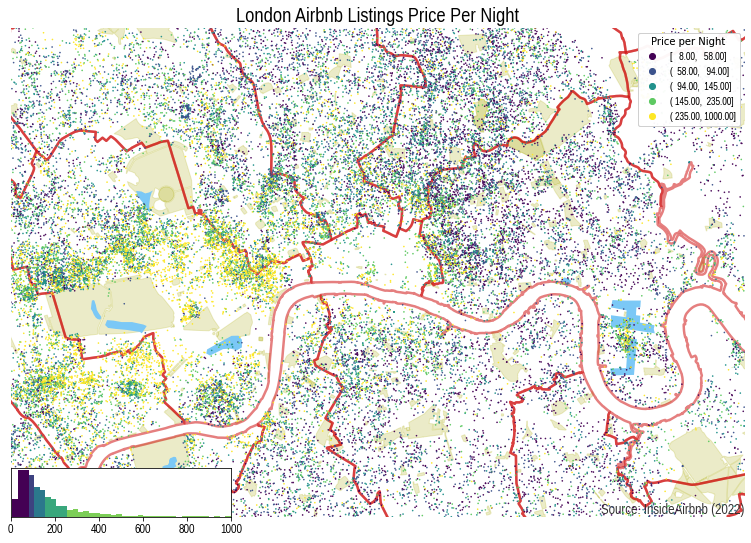

In [87]:
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

fontname = "Liberation Sans Narrow"

tgdf = gdf[(gdf.geometry.x > 525000) & (gdf.geometry.x < 540000) & (gdf.geometry.y > 176000) & (gdf.geometry.y < 186000)].copy()

q = mc.Quantiles(tgdf.price.values, k=5)

tgdf['bins'] = q.yb

f,ax = plt.subplots(figsize=(15,9))
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.25), zorder=1, ax=ax)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', zorder=2, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, zorder=3, ax=ax)

ax.set_xlim([525000,540000])
ax.set_ylim([176000,186000])

ax.axis('off') # Don't plot the axes

tgdf.plot(column='bins', categorical=True,
         cmap='viridis', legend=True, marker='.', markersize=1.5, zorder=4, ax=ax)

ax.set_title('London Airbnb Listings Price Per Night', 
             fontdict={'fontsize':'20', 'fontweight':'3', 'family':fontname})  #provide a title

for c in ax.collections:
    # Find the layer with the data
    if c.get_zorder()==4:

        handles, _ = c.legend_elements(prop="colors")
        legend1 = ax.legend(handles, q.get_legend_classes(fmt='{:.2f}'), 
                            loc="upper right", title="Price per Night", 
                            prop={'size':'10', 'weight':'1', 'family':fontname})
        ax.add_artist(legend1)

# And don't forget to add a source!
a = ax.text(tgdf.geometry.x.max(), tgdf.geometry.y.min(), 'Source: InsideAirbnb (2022)', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=14, fontweight=4, color='#333333', family=fontname)

# And this is a nice feature: show the distribution!
ax2 = legendgram(f, ax, 
           tgdf.price, q.bins, bins=round(gdf.price.max()/25),
           pal=palmpl.Viridis_5,
           legend_size=(0.3, 0.1), 
           loc='lower left',
           clip=(0,1000),
           frameon=True
    )

for tk in ax2.get_xticklabels():
    tk.set_fontname(fontname)
    